In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score
import seaborn as sns
import category_encoders as ce
from matplotlib import rcParams
from sklearn.model_selection import KFold, StratifiedKFold
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP','Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', ]
%matplotlib inline
import optuna
from sklearn.metrics import log_loss
############# Google Colab ################
import lightgbm as lgb
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/My Drive/Titanic/train.csv')
test = pd.read_csv('/content/drive/My Drive/Titanic/test.csv')

In [ ]:
data = pd.concat([train,test],sort=False)

data['honorific'] = data['Name'].map(lambda x : x.split(', ')[1].split('.')[0])
data['honorific'] = data['honorific'].replace(\
['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona','the Countess'], 'Rare')
data['honorific'] = data['honorific'].replace({'Mme':'Mrs','Ms':'Miss','Mlle':'Miss'})
data['Fare'].fillna(np.mean(data['Fare']),inplace=True)
data['Farebin'] = pd.qcut(data['Fare'],4)
for i in range(1,4):
    data.loc[(data['Pclass']==i)&(data['Age'].isnull()),'Age'] = data[data['Pclass']==i]['Age'].mean()
data['Agebin'] = pd.cut(data['Age'].astype(int),5)
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1 # 本人の＋１
data['FamilySize_bin'] = 4
data.loc[data['FamilySize']==1,'FamilySize_bin'] = 1
data.loc[(data['FamilySize']>=2)&(data['FamilySize']<=5),'FamilySize_bin'] = 2
data.loc[(data['FamilySize']>=6)&(data['FamilySize']<=8),'FamilySize_bin'] = 3
data['Cabin_initial'] = data['Cabin'].map(lambda x:str(x)[0])
data['Survived'].groupby(data['Cabin_initial']).mean()
data['Cabin_initial'] = data['Cabin_initial'].replace('T','n')
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].fillna('S',inplace=True)
data['Embarked']=data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket','Cabin','FamilySize']
data.drop(delete_columns, axis=1, inplace=True)

# ラベルエンコーディング
label_category = ['honorific','FamilySize_bin','Cabin_initial','Pclass']
ce_oe = ce.OrdinalEncoder(cols=label_category,handle_unknown='impute')
data = ce_oe.fit_transform(data)

# １からではなく、０から始まりに修正
for i in label_category:
    data[i] = data[i] -1 
    data[i] = data[i].astype('category')

# 元データに戻す
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived',axis=1)
X_test = test.drop('Survived',axis=1)

#### サイズ確認

In [48]:
# print('The size of train data' + str(train.shape))
# print('The size of train data' + str(test.shape))


The size of train data(891, 12)
The size of train data(418, 11)


#### 生存率の確認

In [50]:
# surviverate = train['Survived'].mean()
# print('生存率:',f'{surviverate:.2%}')

生存率: 38.38%


#### 欠損値確認
- Survived列がないtestデータを結合しているので、Survivedの欠損値は無視

In [56]:
# data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

### 特徴量エンジニアリング
- PassengerId: 乗客のID
- Survived: 生存(1)、死亡(0)
- Pclass: 乗客の階級
- Name: 乗客の名前
- Sex: 性別
- Age: 年齢
- SibSp: タイタニック号に乗っていた兄弟、姉妹、義兄弟、義姉妹、夫、妻の数（自分を除く）
- Parch: タイタニック号に乗っていた母親、父親、息子、娘の数
- Ticket: チケットナンバー
- Fare: 乗船料金
- Cabin: キャビン番号
- Embarked: 乗船場

### PassengerId

削除

### Survived
目的変数

### Pclass

In [53]:
# data['Survived'].groupby(data['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

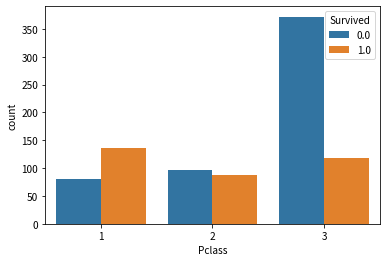

In [55]:
# sns.countplot(data['Pclass'],hue=data['Survived'])
# plt.show()

In [57]:
# Pclassの分布
# Survivedに欠損値アリ＝テストデータ、ナシ＝トレーニングデータ
# pd.crosstab(data['Pclass'],data['Survived'].isnull(),normalize='columns')

Survived,False,True
Pclass,,
1,0.242424,0.255981
2,0.206510,0.222488
3,0.551066,0.521531


### Name

In [60]:
# data['Name'].value_counts()

Kelly, Mr. James                                   2
Connolly, Miss. Kate                               2
Petroff, Mr. Pastcho ("Pentcho")                   1
Mallet, Master. Andre                              1
Scanlan, Mr. James                                 1
                                                  ..
Behr, Mr. Karl Howell                              1
Aronsson, Mr. Ernst Axel Algot                     1
Perkin, Mr. John Henry                             1
Skoog, Mrs. William (Anna Bernhardina Karlsson)    1
Carter, Mr. William Ernest                         1
Name: Name, Length: 1307, dtype: int64

同じ名前の人がいるが、別人と考えておく

In [61]:
# data[data['Name']=='Kelly, Mr. James']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
696,697,0.0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [63]:
# data[data['Name']=='Connolly, Miss. Kate']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
289,290,1.0,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q
6,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q


Nameからは、敬称（Mr, Miss等）を抽出しておく

In [65]:
# data['honorific'] = data['Name'].map(lambda x : x.split(', ')[1].split('.')[0])

In [66]:
# data['Survived'].groupby(data['honorific']).mean()

honorific
Capt            0.000000
Col             0.500000
Don             0.000000
Dona                 NaN
Dr              0.428571
Jonkheer        0.000000
Lady            1.000000
Major           0.500000
Master          0.575000
Miss            0.697802
Mlle            1.000000
Mme             1.000000
Mr              0.156673
Mrs             0.792000
Ms              1.000000
Rev             0.000000
Sir             1.000000
the Countess    1.000000
Name: Survived, dtype: float64

In [67]:
data['honorific'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Sir               1
Capt              1
the Countess      1
Dona              1
Lady              1
Don               1
Mme               1
Jonkheer          1
Name: honorific, dtype: int64

In [74]:
data['honorific'] = data['honorific'].replace(\
['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona','the Countess'], 'Rare')

data['honorific'] = data['honorific'].replace({'Mme':'Mrs','Ms':'Miss','Mlle':'Miss'})

In [75]:
# Salutation_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4} 
# data['honorific'] = data['honorific'].map(Salutation_mapping)

In [76]:
pd.crosstab(data['honorific'],data['Survived'])

Survived,0.0,1.0
honorific,,
Master,17,23
Miss,55,130
Mr,436,81
Mrs,26,100
Rare,15,8


### Fare

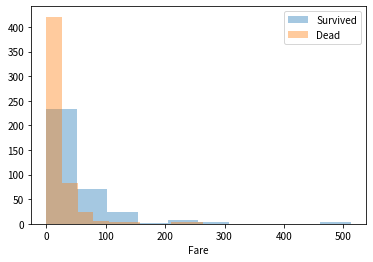

In [77]:
sns.distplot(data[data['Survived']==1]['Fare'],kde=False,rug=False,bins=10,label='Survived')
sns.distplot(data[data['Survived']==0]['Fare'],kde=False,rug=False,bins=10,label='Dead')
plt.legend()
plt.show()

In [78]:
data['Fare'].fillna(np.mean(data['Fare']),inplace=True)


### Age
全体平均から算出するのではなく、欠損値のないPclassに応じて平均値を代入

In [80]:
# 欠損値がある＝生存率が低いかどうか
data['Survived'].groupby(data['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

In [82]:
data.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,672.492260,0.629630,39.159930,0.436533,0.365325,87.508992
2,671.566787,0.472826,29.506705,0.393502,0.368231,21.179196
3,640.558533,0.242363,24.816367,0.568406,0.400564,13.331087


In [104]:
age_pclass = data[data['Age'].isnull()]['Pclass'].value_counts()

In [105]:
total_pclass = data['Pclass'].value_counts()

In [106]:
print(age_pclass[3]/age_pclass.sum())
print(total_pclass[3]/total_pclass.sum())

0.7908745247148289
0.5416348357524828


クラスごとの平均値を代入したほうがいい

In [129]:
for i in range(1,4):
    data.loc[(data['Pclass']==i)&(data['Age'].isnull()),'Age'] = data[data['Pclass']==i]['Age'].mean()

### SibSp,Parch

In [133]:
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1 # 本人の＋１


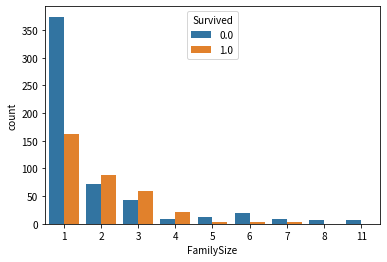

In [136]:
sns.countplot(data['FamilySize'],hue=data['Survived'])

In [137]:
# ビニング処理をする
data['FamilySize_bin'] = 'big'
data.loc[data['FamilySize']==1,'FamilySize_bin'] = 'alone'
data.loc[(data['FamilySize']>=2)&(data['FamilySize']<=5),'FamilySize_bin'] = 'small' 
data.loc[(data['FamilySize']>=6)&(data['FamilySize']<=8),'FamilySize_bin'] = 'mediun'


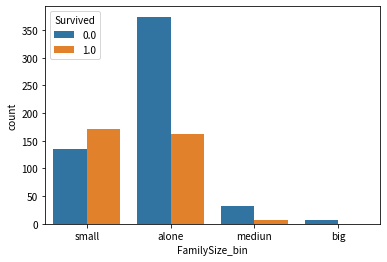

In [138]:
sns.countplot(data['FamilySize_bin'],hue=data['Survived'])

In [139]:
data['Survived'].groupby(data['FamilySize_bin']).mean()

FamilySize_bin
alone     0.303538
big       0.000000
mediun    0.175000
small     0.560261
Name: Survived, dtype: float64

### Cabin

In [142]:
data['Cabin_initial'] = data['Cabin'].map(lambda x:str(x)[0])
data['Survived'].groupby(data['Cabin_initial']).mean()
data['Cabin_initial'] = data['Cabin_initial'].replace('T','n')


In [143]:
data['Survived'].groupby(data['Cabin_initial']).mean()

Cabin_initial
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
n    0.299419
Name: Survived, dtype: float64

### Sex

In [144]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)


### Embarked

In [145]:
data['Embarked'].fillna('S',inplace=True)
data['Embarked']=data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

In [146]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,honorific,FamilySize,FamilySize_bin,Cabin_initial
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,Mr,2,small,n
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,Mrs,2,small,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,Miss,1,alone,n
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,Mrs,2,small,C
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,Mr,1,alone,n


### 不要なカラム削除

In [147]:
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket','Cabin','FamilySize']
data.drop(delete_columns, axis=1, inplace=True)

### カテゴリデータの生成

### データの分割
訓練データとテストデータを元の分割に戻す

In [ ]:
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived',axis=1)
X_test = test.drop('Survived',axis=1)

,Survived,Pclass,Sex,Age,Fare,Embarked,honorific,FamilySize_bin,Cabin_initial
0,NaN,3,0,34.500000,7.8292,2,Mr,alone,n
1,NaN,3,1,47.000000,7.0000,0,Mrs,small,n
2,NaN,2,0,62.000000,9.6875,2,Mr,alone,n
3,NaN,3,0,27.000000,8.6625,0,Mr,alone,n
4,NaN,3,1,22.000000,12.2875,0,Mrs,small,n
...,...,...,...,...,...,...,...,...,...
413,NaN,3,0,24.816367,8.0500,0,Mr,alone,n
414,NaN,1,1,39.000000,108.9000,1,Rare,alone,C
415,NaN,3,0,38.500000,7.2500,0,Mr,alone,n
416,NaN,3,0,24.816367,8.0500,0,Mr,alone,n
